<img src="https://drive.google.com/uc?export=view&id=1JIIlkTWa2xbft5bTpzhGK1BxYL83bJNU" width="800"/>

In [79]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 🔥 Video Search Demo
---

In this demo, we’ll use NOS to build an end-to-end semantic video search utility.

In [80]:
from nos.test.utils import get_benchmark_video
get_benchmark_video()
FILENAME = "test_video.mp4"


In [81]:
from IPython.display import Video
Video(FILENAME, width=640)

#### Frame Inference

Let's embed the video frame by frame with NOS.

In [82]:
from nos.common import tqdm
from nos.common.io.video.opencv import VideoReader
from nos.client import Client, TaskType

client = Client()
client.WaitForServer()
client.IsHealthy()

# Load the first image
images = VideoReader(FILENAME)

In [83]:
from nos.common import tqdm
from nos.common.io.video.opencv import VideoReader
import torch
import numpy as np
from itertools import islice

images = VideoReader(FILENAME)
features = []
for img in tqdm(islice(images, 0, None, 100), position=0, leave=True):
    features.append(client.Run(TaskType.IMAGE_EMBEDDING, "openai/clip", inputs={"images" : img})['embedding'])

print(features)

# normalize embeddings
video_features = torch.from_numpy(np.stack(features))
video_features /= video_features.norm(dim=-1, keepdim=True)

0it [00:00, ?it/s]

[[[210 215 211]
  [210 215 211]
  [210 215 211]
  ...
  [232 232 227]
  [232 232 227]
  [232 232 227]]

 [[210 215 211]
  [210 215 211]
  [210 215 211]
  ...
  [232 232 227]
  [232 232 227]
  [232 232 227]]

 [[210 215 211]
  [210 215 211]
  [210 215 211]
  ...
  [232 232 227]
  [232 232 227]
  [232 232 227]]

 ...

 [[ 99  92  95]
  [105  98 101]
  [104  97 100]
  ...
  [106  84  76]
  [110  82  73]
  [ 88  60  51]]

 [[112 105 108]
  [112 105 108]
  [109 102 105]
  ...
  [103  81  73]
  [107  79  70]
  [ 84  56  47]]

 [[116 109 112]
  [114 107 110]
  [114 107 110]
  ...
  [101  79  71]
  [105  77  68]
  [ 81  53  44]]]


0it [00:06, ?it/s]


KeyboardInterrupt: 

In [75]:
from IPython.display import HTML, display
from nos.common.io import VideoReader
from PIL import Image

video = VideoReader(FILENAME)

def search_video(query: str, video_features: np.ndarray, topk: int = 3):
    """Semantic video search demo in 8 lines of code"""
    # Encode text and normalize
    with torch.inference_mode():
        text_features = client.Run(TaskType.TEXT_EMBEDDING, "openai/clip", inputs={"texts":[query]})["embedding"]
        text_features = torch.from_numpy(text_features)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute the similarity between the search query and each video frame
    similarities = (video_features @ text_features.T)
    _, best_photo_idx = similarities.topk(topk, dim=0)
    
    # Display the top k frames
    results = np.hstack([video[int(frame_id)] for frame_id in best_photo_idx])
    display(Image.fromarray(results).resize((600, 400)))

### 🔍 Sample Queries

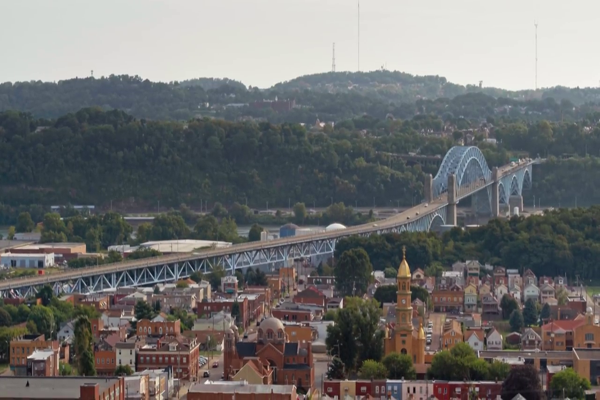

In [76]:
search_video("golden gate bridge", video_features, topk=1)

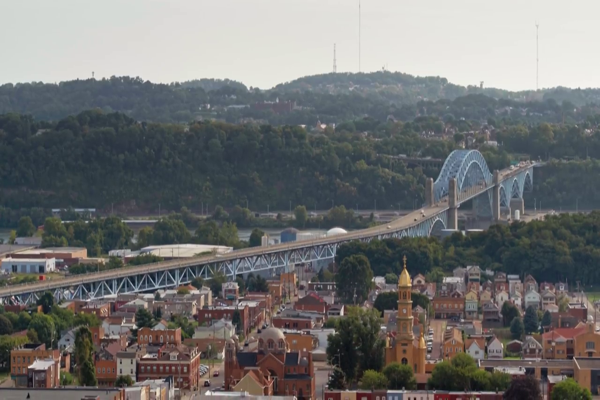

In [77]:
search_video("alcatraz prison", video_features, topk=1)

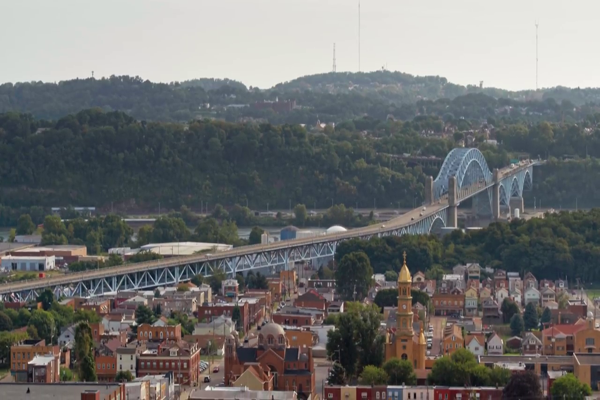

In [78]:
search_video("fishermans wharf", video_features, topk=1)

In [ ]:
search_video("golden gate park windmill", video_features, topk=1)

In [ ]:
search_video("chinatown", video_features, topk=1)

In [ ]:
search_video("lombard street", video_features, topk=1)

In [ ]:
search_video("pier 39", video_features, topk=1)

In [ ]:
search_video("riding the tram", video_features, topk=1)

In [ ]:
search_video("ferry building", video_features, topk=1)